In [1]:
import matplotlib.pyplot as plt # plotting library
import torch.optim as optim
import numpy as np 
import torch
import shutil
import os

from torch.utils.data import DataLoader,random_split
from TwoDigitSumDataset import TwoDigitSumDataset
from IPython.display import clear_output
from utils.utils import plot_ae_outputs, generate_gif, test_acc
from torchvision import transforms
from Encoder import Encoder
from Decoder import Decoder
from tqdm import tqdm

torch.manual_seed(17)

data_dir = 'data/'

train_transform = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.ToTensor()    
])

train_dataset = TwoDigitSumDataset(data_dir, train=True, transform=train_transform, dataset_mult=5)
test_dataset  = TwoDigitSumDataset(data_dir, train=False, transform=test_transform, labels=train_dataset.labels)

In [2]:
m =  len(train_dataset)
batch_size = 256
num_epochs = 100
lr= 0.0001
### Initialize the two networks
latent_space_dim = 20

In [3]:
train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])

train_loader = DataLoader(train_data, batch_size=batch_size)
valid_loader = DataLoader(val_data, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

In [4]:
#model = Autoencoder(encoded_space_dim=encoded_space_dim)
encoder = Encoder(encoded_space_dim=latent_space_dim, fc2_input_dim=128)
decoder = Decoder(encoded_space_dim=latent_space_dim, fc2_input_dim=128)

params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

### Define the loss function
loss_fn = torch.nn.MSELoss()
### Define an optimizer (both for the encoder and the decoder!)
optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

In [5]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)
print(f'Selected device: {device}')

Selected device: cuda


In [6]:
### Training function
def train_epoch_den(encoder, decoder, device, dataloader, loss_fn, optimizer, epoch, num_of_epochs):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []

    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    with tqdm(dataloader, unit="batch") as tepoch:
        for _, (image_batch, (_, y_batch)) in enumerate(tepoch, 0):
            tepoch.set_description(f"Epoch {epoch + 1}/{num_of_epochs}")
            # Move tensor to the proper device
            image = image_batch.to(device)
            y_batch = y_batch.to(device)    
            # Encode data
            encoded_data = encoder(image)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Evaluate loss
            loss = loss_fn(decoded_data, y_batch)
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # Print batch loss
            train_loss.append(loss.detach().cpu().numpy())
            tepoch.set_postfix(loss=loss.item())

    return np.mean(train_loss)

In [7]:
### Testing function
### Controllare che la somma sia corretta
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, (_, y_batch) in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            y_batch = y_batch.to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            conc_out.append(decoded_data.cpu())
            conc_label.append(y_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data


 EPOCH 1/100 
 train loss 0.19224746525287628 	 val loss 0.13761405646800995


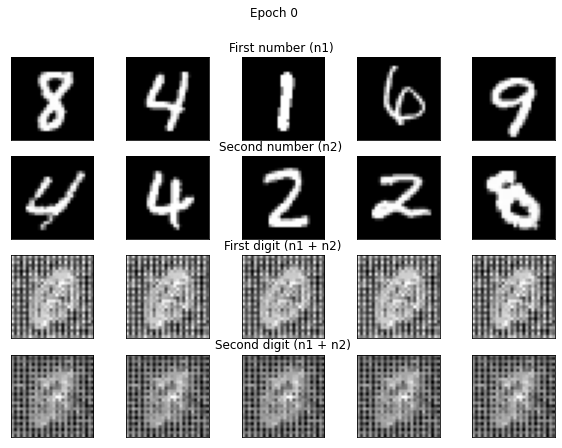

Epoch 2/100: 100%|██████████| 938/938 [03:40<00:00,  4.26batch/s, loss=0.0797]


In [8]:
diz_loss = {'train_loss':[],'val_loss':[]}
train_loss = 0.0
val_loss = 0.0

directory = "outputs/"
if os.path.exists(directory):
   shutil.rmtree(directory)
os.makedirs(directory)

for epoch in range(num_epochs):
   train_loss =train_epoch_den(encoder,decoder,device,train_loader,loss_fn, optim, epoch, num_epochs)
   val_loss = test_epoch(encoder,decoder,device,valid_loader,loss_fn)
   diz_loss['train_loss'].append(train_loss)
   diz_loss['val_loss'].append(val_loss)
   # Printing epoch info
   clear_output(wait=True)
   print('\n EPOCH {}/{} \n train loss {} \t val loss {}'.format(epoch + 1, num_epochs, train_loss,val_loss))
   plot_ae_outputs(encoder,decoder, device, test_dataset, epoch, directory, n=5)

generate_gif()

In [ ]:
test_acc(encoder,decoder,device,test_loader)

Error: Session cannot generate requests

In [ ]:
test_epoch(encoder,decoder,device,test_loader,loss_fn).item()

0.1263485699892044

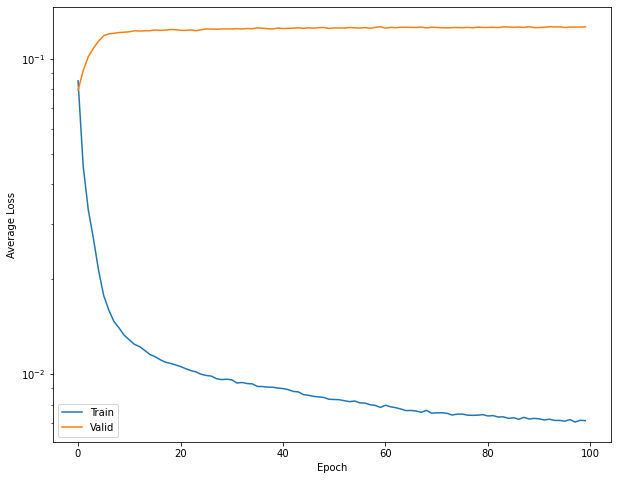

In [ ]:
# Plot losses
plt.figure(figsize=(10,8))
plt.semilogy(diz_loss['train_loss'], label='Train')
plt.semilogy(diz_loss['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()

In [ ]:
torch.save(encoder.state_dict(), "pretrained_model/encoder.pth")
torch.save(decoder.state_dict(), "pretrained_model/decoder.pth")